<a href="https://colab.research.google.com/github/Vic-the-Legend/Transformers-and-NER/blob/main/two_label_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model with two labels

## Import required libraries

In [ ]:
from datasets import load_dataset, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, pipeline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import gc
import torch
from scipy import special

c:\Users\liang\.conda\envs\finbert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Allowing different number of labels:

Do the following when fine-tuning and we can work with 2 labels

In [ ]:
# Specify number of labels when training
num_labels = 2

# Change the number of labels
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = num_labels).to('cuda')

## Generate Sample model for two labels:

In [ ]:
from datasets import load_dataset
phrases = load_dataset('financial_phrasebank', 'sentences_50agree')
data = phrases['train']
data.set_format("pandas")
data = data[:]
data

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,0
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1
4843,Operating profit fell to EUR 35.4 mn from EUR ...,0
4844,Net sales of the Paper segment decreased to EU...,0


### Separating data into negative and non-negative

<Axes: xlabel='label'>

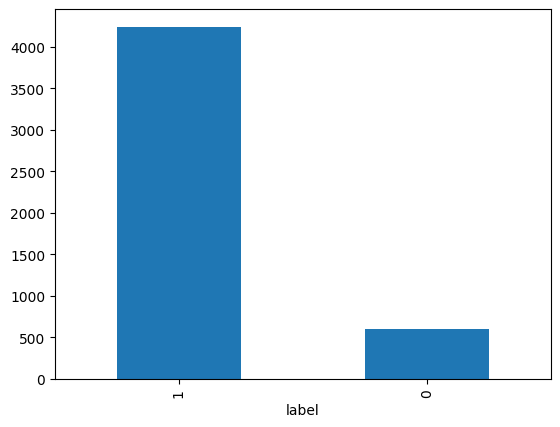

In [ ]:
data["label"] = np.where(data['label'] >= 1, 1, 0)
data["label"].value_counts().plot(kind = 'bar')

### Training the model

In [ ]:
df_train, df_test = train_test_split(data, shuffle = True, test_size=0.2, stratify=data['label'])
df_train, df_val = train_test_split(df_train, test_size=0.125, stratify=df_train['label'])
print(df_train.shape, df_test.shape, df_val.shape)

(3391, 2) (970, 2) (485, 2)


In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
dataset_train_DistilBERT = Dataset.from_pandas(df_train)
dataset_val_DistilBERT = Dataset.from_pandas(df_val)
dataset_test_DistilBERT = Dataset.from_pandas(df_test)

dataset_train_DistilBERT = dataset_train_DistilBERT.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val_DistilBERT = dataset_val_DistilBERT.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test_DistilBERT = dataset_test_DistilBERT.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train_DistilBERT.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_val_DistilBERT.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_test_DistilBERT.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 970/970 [00:00<00:00, 2246.92 examples/s]


In [ ]:
torch.cuda.empty_cache()
gc.collect()

30

Important step:

In [ ]:
num_labels = len(data["label"].unique())
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = num_labels).to('cuda')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

batch_size = 32
logging_steps = df_train.shape[0] // batch_size


args_DistilBERT = TrainingArguments(
        output_dir = 'temp/',
        num_train_epochs=5,
        learning_rate=2e-5,
        warmup_steps = 0,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        #weight_decay=0.01,
        evaluation_strategy = 'epoch',
        logging_steps=logging_steps
        #save_strategy = 'epoch',
        #load_best_model_at_end=True,
        #metric_for_best_model='accuracy',
)

trainer_DistilBERT = Trainer(
        model=model,
        args=args_DistilBERT,
        train_dataset=dataset_train_DistilBERT,         # training dataset
        eval_dataset=dataset_val_DistilBERT,            # evaluation dataset
        compute_metrics=compute_metrics
)

trainer_DistilBERT.train()

 20%|█▉        | 105/530 [00:30<01:47,  3.96it/s]

{'loss': 0.2542, 'learning_rate': 1.6037735849056607e-05, 'epoch': 0.99}


                                                 
 20%|██        | 106/530 [00:31<01:48,  3.89it/s]

{'eval_loss': 0.13089308142662048, 'eval_accuracy': 0.9443298969072165, 'eval_f1': 0.9423646369987716, 'eval_runtime': 1.2607, 'eval_samples_per_second': 384.699, 'eval_steps_per_second': 12.691, 'epoch': 1.0}


 40%|███▉      | 210/530 [00:57<01:21,  3.91it/s]

{'loss': 0.115, 'learning_rate': 1.2075471698113209e-05, 'epoch': 1.98}


                                                 
 40%|████      | 212/530 [00:59<01:20,  3.96it/s]

{'eval_loss': 0.123526930809021, 'eval_accuracy': 0.9567010309278351, 'eval_f1': 0.9571523865532597, 'eval_runtime': 1.2452, 'eval_samples_per_second': 389.507, 'eval_steps_per_second': 12.85, 'epoch': 2.0}


 59%|█████▉    | 315/530 [01:27<01:03,  3.38it/s]

{'loss': 0.0604, 'learning_rate': 8.113207547169812e-06, 'epoch': 2.97}


                                                 
 60%|██████    | 318/530 [01:29<01:01,  3.47it/s]

{'eval_loss': 0.13153932988643646, 'eval_accuracy': 0.9628865979381444, 'eval_f1': 0.9623336283281618, 'eval_runtime': 1.6141, 'eval_samples_per_second': 300.474, 'eval_steps_per_second': 9.913, 'epoch': 3.0}


 79%|███████▉  | 420/530 [02:01<00:37,  2.90it/s]

{'loss': 0.0262, 'learning_rate': 4.150943396226416e-06, 'epoch': 3.96}


                                                 
 80%|████████  | 424/530 [02:04<00:35,  3.01it/s]

{'eval_loss': 0.14903795719146729, 'eval_accuracy': 0.954639175257732, 'eval_f1': 0.955263565470954, 'eval_runtime': 1.6006, 'eval_samples_per_second': 303.009, 'eval_steps_per_second': 9.996, 'epoch': 4.0}


 99%|█████████▉| 525/530 [02:38<00:01,  3.10it/s]

{'loss': 0.0166, 'learning_rate': 1.886792452830189e-07, 'epoch': 4.95}


                                                 
100%|██████████| 530/530 [02:42<00:00,  3.27it/s]

{'eval_loss': 0.15571780502796173, 'eval_accuracy': 0.954639175257732, 'eval_f1': 0.9549574937579918, 'eval_runtime': 1.6409, 'eval_samples_per_second': 295.562, 'eval_steps_per_second': 9.751, 'epoch': 5.0}
{'train_runtime': 162.0139, 'train_samples_per_second': 104.651, 'train_steps_per_second': 3.271, 'train_loss': 0.09380716200707094, 'epoch': 5.0}


TrainOutput(global_step=530, training_loss=0.09380716200707094, metrics={'train_runtime': 162.0139, 'train_samples_per_second': 104.651, 'train_steps_per_second': 3.271, 'train_loss': 0.09380716200707094, 'epoch': 5.0})

In [ ]:
trainer_DistilBERT.evaluate()

100%|██████████| 16/16 [00:01<00:00, 11.98it/s]


{'eval_loss': 0.15571780502796173,
 'eval_accuracy': 0.954639175257732,
 'eval_f1': 0.9549574937579918,
 'eval_runtime': 1.6454,
 'eval_samples_per_second': 294.755,
 'eval_steps_per_second': 9.724,
 'epoch': 5.0}

In [ ]:
def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [ ]:
prediction = trainer_DistilBERT.predict(dataset_test_DistilBERT)

100%|██████████| 31/31 [00:02<00:00, 13.25it/s]


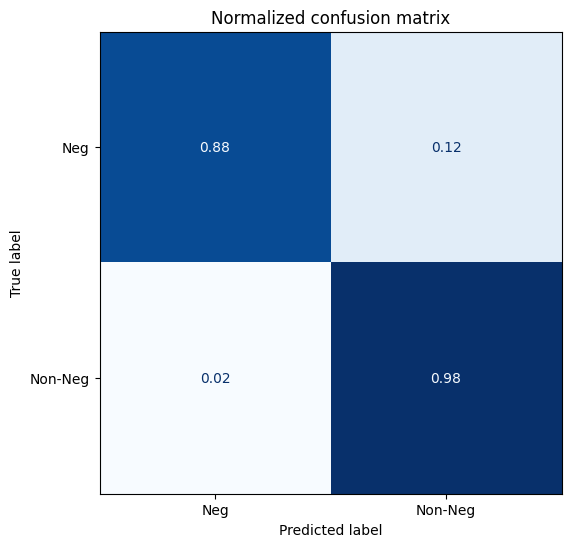

In [ ]:
plot_confusion_matrix(np.argmax(prediction.predictions, axis=1), df_test['label'], ["Neg", "Non-Neg"])

### Save model:

In [ ]:
save_directory = "two_label/"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('two_label/tokenizer_config.json',
 'two_label/special_tokens_map.json',
 'two_label/vocab.txt',
 'two_label/added_tokens.json')

### Test saved model:

In [ ]:
# Directory of saved tuned model on financial phrase data
save_directory = "two_label/"
model = DistilBertForSequenceClassification.from_pretrained(save_directory)
tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
trained_model = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer) # top_k = None allows for all probabilities to show

In [ ]:
predictions = trained_model.predict(df_test["sentence"].tolist())

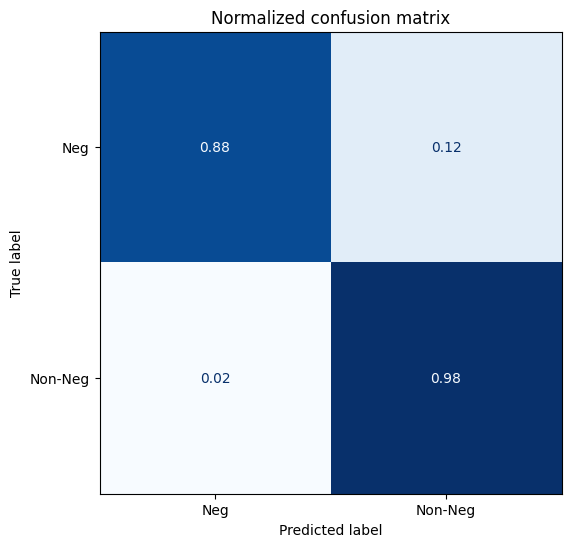

In [ ]:
indices = [int(pred['label'][-1]) for pred in predictions]
plot_confusion_matrix(indices, df_test['label'], ["Neg", "Non-Neg"])

We can see the results are the same, the resulting model could be used as a two-label classifier